# Brain Tumor Detection Using a Convolutional Neural Network

**About the Brain MRI Images dataset:**<br>
The dataset contains 2 folders: yes and no which contains 253 Brain MRI Images. The folder yes contains 155 Brain MRI Images that are tumorous and the folder no contains 98 Brain MRI Images that are non-tumorous. You can find it [here](https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection).

## Import Necessary Modules

In [0]:
# import tensorflow as tf
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

Using TensorFlow backend.


## Data Preparation & Preprocessing

We have cropped the image in such a way that only brain boundary part should come using  [Finding extreme points in contours with OpenCV](https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/).

In [0]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

for example:


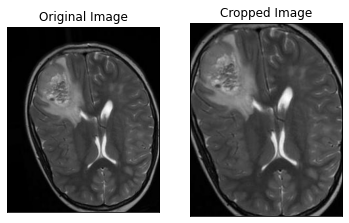

In [0]:
ex_img = cv2.imread('/content/drive/My Drive/MRI_Data/augmented_data/yes/aug_Y100_0_1097.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

### Load up the data:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


The following function takes two arguments, the first one is a list of directory paths for the folders 'yes' and 'no' that contain the image data and the second argument is the image size, and for every image in both directories and does the following: 
1. Read the image.
2. Crop the part of the image representing only the brain.
3. Resize the image (because the images in the dataset come in different sizes (meaning width, height and # of channels). So, we want all of our images to be (240, 240, 3) to feed it as an input to the neural network.
4. Apply normalization because we want pixel values to be scaled to the range 0-1.
5. Append the image to <i>X</i> and its label to <i>y</i>.<br>

After that, Shuffle <i>X</i> and <i>y</i>, because the data is ordered (meaning the arrays contains the first part belonging to one class and the second part belonging to the other class, and we don't want that).<br>
Finally, Return <i>X</i> and <i>y</i>.

In [0]:
def load_data(dir_list, image_size):
    

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            print(directory + '/' + filename)
            # load the image
            image = cv2.imread(directory + '/' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

Load up the data that we augmented earlier in the Data Augmentation notebook.<br>
**Note:** the augmented data directory contains not only the new generated images but also the original images.

In [0]:
augmented_path = '/content/drive/My Drive/MRI_Data/augmented_data/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

/content/drive/My Drive/MRI_Data/augmented_data/yes/aug_Y116_0_3112.jpg
/content/drive/My Drive/MRI_Data/augmented_data/yes/aug_Y116_0_678.jpg
/content/drive/My Drive/MRI_Data/augmented_data/yes/aug_Y116_0_8540.jpg
/content/drive/My Drive/MRI_Data/augmented_data/yes/aug_Y116_0_5701.jpg
/content/drive/My Drive/MRI_Data/augmented_data/yes/aug_Y116_0_2550.jpg
/content/drive/My Drive/MRI_Data/augmented_data/yes/aug_Y116_0_369.jpg
/content/drive/My Drive/MRI_Data/augmented_data/yes/aug_Y115_0_79.jpg
/content/drive/My Drive/MRI_Data/augmented_data/yes/aug_Y115_0_9505.jpg
/content/drive/My Drive/MRI_Data/augmented_data/yes/aug_Y115_0_275.jpg
/content/drive/My Drive/MRI_Data/augmented_data/yes/aug_Y115_0_638.jpg
/content/drive/My Drive/MRI_Data/augmented_data/yes/aug_Y115_0_1938.jpg
/content/drive/My Drive/MRI_Data/augmented_data/yes/aug_Y115_0_5787.jpg
/content/drive/My Drive/MRI_Data/augmented_data/yes/aug_Y115_0_1704.jpg
/content/drive/My Drive/MRI_Data/augmented_data/yes/aug_Y117_0_4764.jp

As we see, we have 2065 images. Each images has a shape of **(240, 240, 3)=(image_width, image_height, number_of_channels)**

### Plot sample images:

In [0]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

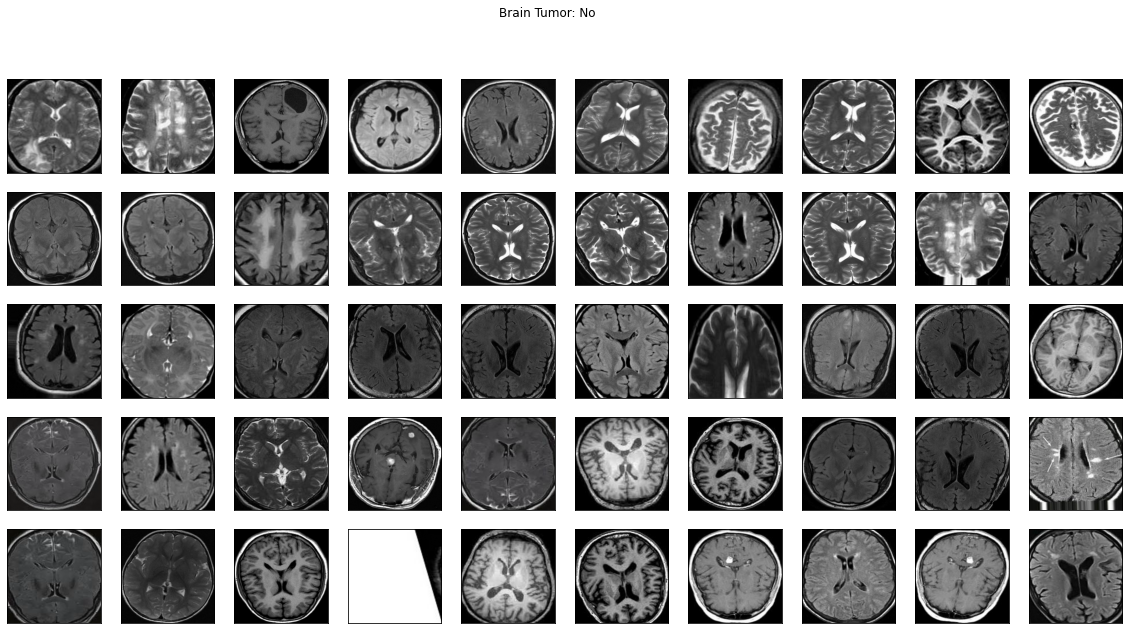

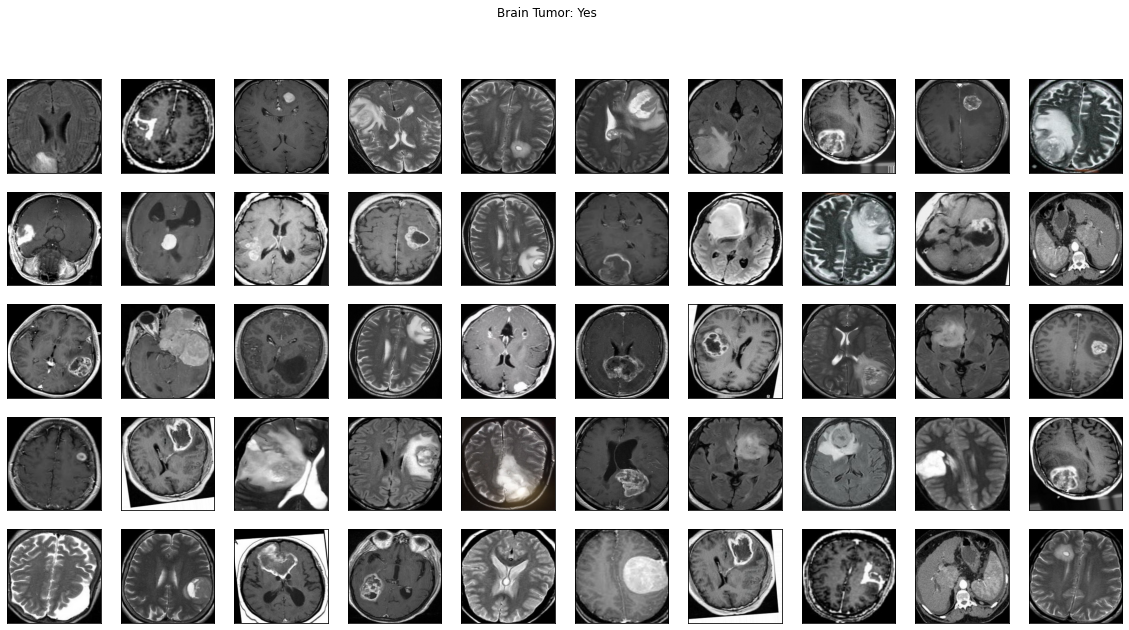

In [0]:
plot_sample_images(X, y)

### Split the data:
Split <i>X</i> and <i>y</i> into training, validation (development) and validation sets.

In [0]:
def split_data(X, y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

Let's use the following way to split:<br>
1. 70% of the data for training.
2. 15% of the data for validation.
3. 15% of the data for testing.

In [0]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [0]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1445
number of development examples = 310
number of test examples = 310
X_train shape: (1445, 240, 240, 3)
Y_train shape: (1445, 1)
X_val (dev) shape: (310, 240, 240, 3)
Y_val (dev) shape: (310, 1)
X_test shape: (310, 240, 240, 3)
Y_test shape: (310, 1)


Some helper functions:

In [0]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [0]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

# Build the model

Let's build a convolutional neural network model:

In [0]:
def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainTumourDetectionModel')
    
    return model

Define the image shape:

In [0]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [0]:
model = build_model(IMG_SHAPE)

In [0]:
model.summary()

Model: "BrainTumourDetectionModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 240, 240, 3)       0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 244, 244, 3)       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 238, 238, 32)      4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 238, 238, 32)      128       
_________________________________________________________________
activation_2 (Activation)    (None, 238, 238, 32)      0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 59, 59, 32)        0         
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 14, 1

Compile the model:

In [0]:
!pwd


/content


In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [0]:
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath="cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))

## Train the model

In [0]:
!mkdir models


In [0]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Train on 1445 samples, validate on 310 samples
Epoch 1/10
1445/1445 [==============================] - 135s 93ms/step - loss: 0.1545 - accuracy: 0.9460 - val_loss: 0.4649 - val_accuracy: 0.8000
Epoch 2/10
1445/1445 [==============================] - 135s 93ms/step - loss: 0.1431 - accuracy: 0.9550 - val_loss: 0.5887 - val_accuracy: 0.7806
Epoch 3/10
1445/1445 [==============================] - 135s 93ms/step - loss: 0.1304 - accuracy: 0.9543 - val_loss: 0.5961 - val_accuracy: 0.7677
Epoch 4/10
1445/1445 [==============================] - 135s 93ms/step - loss: 0.1720 - accuracy: 0.9349 - val_loss: 0.4720 - val_accuracy: 0.8290
Epoch 5/10
1445/1445 [==============================] - 135s 94ms/step - loss: 0.1487 - accuracy: 0.9329 - val_loss: 0.4990 - val_accuracy: 0.8194
Epoch 6/10
1445/1445 [==============================] - 135s 93ms/step - loss: 0.1118 - accuracy: 0.9619 - val_loss: 0.6836 - val_accuracy: 0.7516
Epoch 7/10
1445/1445 [==============================] - 135s 93ms/step 

Let's train for a few more epochs:

In [0]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Train on 1445 samples, validate on 310 samples
Epoch 1/3
1445/1445 [==============================] - 135s 93ms/step - loss: 0.0821 - accuracy: 0.9751 - val_loss: 0.4420 - val_accuracy: 0.8290
Epoch 2/3
1445/1445 [==============================] - 135s 93ms/step - loss: 0.0632 - accuracy: 0.9869 - val_loss: 0.3611 - val_accuracy: 0.8742
Epoch 3/3
1445/1445 [==============================] - 135s 93ms/step - loss: 0.0614 - accuracy: 0.9917 - val_loss: 0.3061 - val_accuracy: 0.8742
Elapsed time: 0:6:44.6


In [0]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Train on 1445 samples, validate on 310 samples
Epoch 1/3
1445/1445 [==============================] - 136s 94ms/step - loss: 0.0518 - accuracy: 0.9958 - val_loss: 0.3182 - val_accuracy: 0.8839
Epoch 2/3
1445/1445 [==============================] - 135s 93ms/step - loss: 0.0516 - accuracy: 0.9903 - val_loss: 0.3070 - val_accuracy: 0.8903
Epoch 3/3
1445/1445 [==============================] - 135s 93ms/step - loss: 0.1230 - accuracy: 0.9536 - val_loss: 0.2958 - val_accuracy: 0.8935
Elapsed time: 0:6:45.5


In [0]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Train on 1445 samples, validate on 310 samples
Epoch 1/3
1445/1445 [==============================] - 135s 93ms/step - loss: 0.0538 - accuracy: 0.9903 - val_loss: 0.3708 - val_accuracy: 0.8677
Epoch 2/3
1445/1445 [==============================] - 135s 94ms/step - loss: 0.1075 - accuracy: 0.9578 - val_loss: 0.3273 - val_accuracy: 0.8774
Epoch 3/3
1445/1445 [==============================] - 134s 93ms/step - loss: 0.0637 - accuracy: 0.9862 - val_loss: 0.4353 - val_accuracy: 0.8419
Elapsed time: 0:6:44.5


In [0]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Train on 1445 samples, validate on 310 samples
Epoch 1/5
1445/1445 [==============================] - 134s 93ms/step - loss: 0.0491 - accuracy: 0.9917 - val_loss: 0.3338 - val_accuracy: 0.8871
Epoch 2/5
1445/1445 [==============================] - 134s 93ms/step - loss: 0.0409 - accuracy: 0.9924 - val_loss: 0.3055 - val_accuracy: 0.8871
Epoch 3/5
1445/1445 [==============================] - 134s 93ms/step - loss: 0.0317 - accuracy: 0.9993 - val_loss: 0.4362 - val_accuracy: 0.8548
Epoch 4/5
1445/1445 [==============================] - 135s 93ms/step - loss: 0.0311 - accuracy: 0.9986 - val_loss: 0.2965 - val_accuracy: 0.8935
Epoch 5/5
1445/1445 [==============================] - 135s 93ms/step - loss: 0.0318 - accuracy: 0.9972 - val_loss: 0.3036 - val_accuracy: 0.8871
Elapsed time: 0:11:12.6


In [0]:
history = model.history.history

In [0]:
for key in history.keys():
    print(key)

val_loss
val_accuracy
loss
accuracy


## Plot Loss & Accuracy

In [0]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

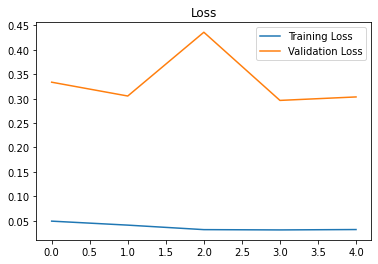

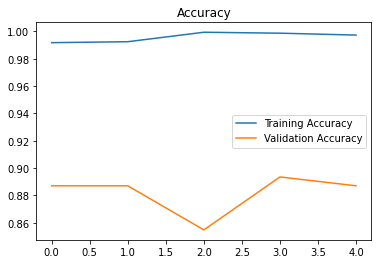

In [0]:
plot_metrics(history) 

# Results

Let's experiment with the best model (the one with the best validation accuracy):

 accuracy of 89.9%

### Load the best model

In [0]:
best_model = load_model('models/cnn-parameters-improvement-05-0.89.model')

In [59]:
best_model.metrics_names

['loss', 'accuracy']

Evaluate the best model on the testing data:

In [60]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)

310/310 [==============================] - 10s 32ms/step


### Accuracy of the best model on the testing data:

In [61]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.3265362089680087
Test Accuracy = 0.8999999761581421


### F1 score for the best model on the testing data:

In [0]:
y_test_prob = best_model.predict(X_test)

In [64]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.9040247678018576


Let's also find the f1 score on the validation data:

In [0]:
y_val_prob = best_model.predict(X_val)

In [66]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.890282131661442


### Results Interpretation

In [0]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}") 



In [68]:
# the whole data
data_percentage(y)

Number of examples: 2065
Percentage of positive examples: 52.54237288135593%, number of pos examples: 1085
Percentage of negative examples: 47.45762711864407%, number of neg examples: 980


In [69]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 1445
Percentage of positive examples: 53.0795847750865%, number of pos examples: 767
Percentage of negative examples: 46.9204152249135%, number of neg examples: 678
Validation Data:
Number of examples: 310
Percentage of positive examples: 50.645161290322584%, number of pos examples: 157
Percentage of negative examples: 49.354838709677416%, number of neg examples: 153
Testing Data:
Number of examples: 310
Percentage of positive examples: 51.935483870967744%, number of pos examples: 161
Percentage of negative examples: 48.064516129032256%, number of neg examples: 149


# Conclusion:

#### Now, the model detects brain tumor with:<br>
**90%** accuracy on the **test set**.<br>
**0.90** f1 score on the **test set**.<br>


**Performance Table:**

| <!-- -->  | Validation set | Test set |
| --------- | -------------- | -------- |
| Accuracy  | 89%            | 90%      |
| F1 score  | 0.89           | 0.90     |